<a href="https://colab.research.google.com/github/guipeeix7/Quality-Education---ENEM/blob/main/ModeloFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data

In [ ]:
import os 

dir_base = '/content/drive/MyDrive/ML Olympiad Kaggle'
train = pd.read_csv(os.path.join(dir_base, 'train.csv'))#.sample(n = 10000)
#test = pd.read_csv(os.path.join(dir_base, 'test.csv'))


In [ ]:
train.shape

(10000, 118)

In [ ]:
train_tested = train.query('TP_PRESENCA_CN == 1 and TP_PRESENCA_CH == 1 and TP_PRESENCA_LC == 1 and TP_PRESENCA_MT == 1 and TP_STATUS_REDACAO == 1')

Y = train_tested.filter(['NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_MT','NU_NOTA_REDACAO'])

In [ ]:
print(
"Base de Treino: ", train_tested.shape, '\n',
)

Base de Treino:  (7021, 118) 



# Feature Engineering

In [ ]:
Qs = []

for i in range(1,26):
    if i < 10:
        q = 'Q00' + str(i)
    else:
        q = 'Q0' + str(i)
    Qs.append(q)


features = ['NO_MUNICIPIO_RESIDENCIA', 'TP_ESCOLA','SG_UF_RESIDENCIA', 'CO_ESCOLA','NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL', 
            'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU'] + Qs

target = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']

abt = train_tested.loc[:, features + target].copy()

In [ ]:
averageAge = round(abt['NU_IDADE'].mean(),3)
abt['NU_IDADE'] = abt['NU_IDADE'].fillna(averageAge)

## Municipios

In [ ]:
listaMuncs = abt.NO_MUNICIPIO_RESIDENCIA.value_counts().sort_values(ascending = False).index.tolist()[:85]

In [ ]:
abt.head()

,NO_MUNICIPIO_RESIDENCIA,TP_ESCOLA,SG_UF_RESIDENCIA,CO_ESCOLA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,...,Q021,Q022,Q023,Q024,Q025,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
445221,Águas Belas,1,PE,NaN,29.0,F,1,3,1,1,...,A,B,A,A,A,404.5,423.4,450.6,389.5,460.0
1496159,Baependi,1,MG,NaN,20.0,F,1,1,1,1,...,A,D,A,A,B,372.4,458.3,486.7,431.5,600.0
2048367,Tomé-Açu,2,PA,NaN,18.0,F,1,1,1,2,...,A,C,A,A,A,438.6,481.4,519.2,417.1,540.0
2843208,Monte Alto,3,SP,NaN,17.0,F,1,1,1,2,...,A,D,B,B,B,613.6,622.3,569.6,632.8,880.0
713921,Belém,1,PA,NaN,20.0,M,1,1,1,1,...,A,D,A,B,A,425.1,461.7,513.0,407.5,560.0


In [ ]:
def CidadeGrande(col):
    if col not in listaMuncs:
        return 0
    else:
        return 1

abt['CIDADE_GRANDE'] = abt.NO_MUNICIPIO_RESIDENCIA.apply(CidadeGrande)

# Encoding

In [ ]:
from sklearn import preprocessing


### QsDF

In [ ]:
le_QsDF = preprocessing.LabelEncoder()

QsDF = abt.loc[:, Qs]

QsDF = QsDF.apply(le_QsDF.fit_transform)

scaler_QsDF = preprocessing.MinMaxScaler()

QsDF = pd.DataFrame(scaler_QsDF.fit_transform(QsDF), columns = QsDF.columns)

QsDF.head()

,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,0.285714,0.285714,0.0,0.0,0.142857,0.0625,0.0,0.25,0.50,0.00,...,0.00,0.0,0.0,0.25,0.0,0.0,0.25,0.0,0.00,0.0
1,0.285714,0.571429,0.4,0.2,0.142857,0.1875,0.0,0.25,0.50,0.25,...,0.00,0.0,0.0,0.25,1.0,0.0,0.75,0.0,0.00,1.0
2,0.571429,0.285714,0.0,0.0,0.214286,0.0000,0.0,0.25,0.50,0.00,...,0.00,0.0,0.0,0.25,0.0,0.0,0.50,0.0,0.00,0.0
3,0.571429,0.857143,0.0,0.6,0.142857,0.3125,0.0,0.25,0.50,0.50,...,0.25,0.0,0.0,0.50,1.0,0.0,0.75,1.0,0.25,1.0
4,0.714286,0.428571,0.6,0.2,0.214286,0.2500,0.0,0.50,0.75,0.25,...,0.25,0.0,0.0,0.25,0.0,0.0,0.75,0.0,0.25,0.0


In [ ]:
#QsDF['Media_Q001-002'] = QsDF[['Q001', 'Q002']].mean(axis = 1)
#QsDF['Media_Q003-004'] = QsDF[['Q002', 'Q004']].mean(axis = 1)
#QsDF['Media_QsCASA'] = np.sqrt((QsDF.iloc[:, 7:] ** 2).sum(axis = 1)/QsDF.iloc[:, 7:].shape[1])

#QsDF = QsDF ** 2

In [ ]:
#cols = ['Q001', 'Q002', 'Q003', 'Q004']

#QsDF.drop(cols, axis =1 , inplace = True)

In [ ]:
#QsDF = QsDF[['Media_Q001-002', 'Media_Q003-004', 'Media_QsCASA']].copy()

### TpInDF

In [ ]:
le_TpInDF = preprocessing.LabelEncoder()

cols = ['TP_SEXO', 'TP_COR_RACA']

TpInDF = abt[cols].apply(le_TpInDF.fit_transform)
TpInDF = pd.concat([abt[['NU_IDADE', 'CO_ESCOLA','TP_ESCOLA', 'CIDADE_GRANDE', 'TP_ESTADO_CIVIL','TP_ANO_CONCLUIU']], TpInDF ], axis=1)

scaler_TpInDF = preprocessing.MinMaxScaler()

TpInDF = pd.DataFrame(scaler_TpInDF.fit_transform(TpInDF), columns = TpInDF.columns)
TpInDF.head()

TpInDF.head()

,NU_IDADE,CO_ESCOLA,TP_ESCOLA,CIDADE_GRANDE,TP_ESTADO_CIVIL,TP_ANO_CONCLUIU,TP_SEXO,TP_COR_RACA
0,0.234375,NaN,0.0,0.0,0.25,0.538462,0.0,0.6
1,0.093750,NaN,0.0,0.0,0.25,0.153846,0.0,0.2
2,0.062500,NaN,0.5,0.0,0.25,0.000000,0.0,0.2
3,0.046875,NaN,1.0,0.0,0.25,0.000000,0.0,0.2
4,0.093750,NaN,0.0,1.0,0.25,0.230769,1.0,0.2


### Nota Escola

In [ ]:
# train_tested.loc[:, features + target].copy()
#Agrupando escolas por código
grouped_schools = train_tested[train_tested['CO_ESCOLA'].notna()].groupby('CO_ESCOLA')

#Selecionando as colunas que serão utilizadas para o calculo da nota geral
cols = ['CO_ESCOLA', 'NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_REDACAO']
#Fazendo o calculo da média a partir da nota das provas de cada Escola
grouped_schools = train_tested[cols].groupby(['CO_ESCOLA']).agg(
  NU_NOTA_MT=('NU_NOTA_MT', 'median'), NU_NOTA_LC=('NU_NOTA_LC', 'median'), NU_NOTA_CN=('NU_NOTA_CN', 'median'), NU_NOTA_CH=('NU_NOTA_CH', 'median'),
  NU_NOTA_REDACAO = ('NU_NOTA_REDACAO', 'median'), N_SAMPLES =('CO_ESCOLA', 'count')
)
#Funçao que calcula a nota da prova por pesos (calculo inep para nota geral)
def note_by_weight(row):
  geranNote = ((row['NU_NOTA_CH']*2)+(row['NU_NOTA_CN']*1)+(row['NU_NOTA_MT']*1)+(row['NU_NOTA_LC']*2) + (row['NU_NOTA_REDACAO']*3))/9
  return geranNote

#Criando uma coluna para nota geral
grouped_schools['NU_GERAL_BY_SCHOOL'] = grouped_schools.apply(lambda row: note_by_weight(row), axis=1)

grouped_schools.head()

,NU_NOTA_MT,NU_NOTA_LC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_REDACAO,N_SAMPLES,NU_GERAL_BY_SCHOOL
CO_ESCOLA,,,,,,,
11003065.0,470.6,514.5,398.0,479.6,560.0,1,504.088889
11003839.0,408.9,401.8,363.5,425.7,500.0,1,436.377778
11007893.0,597.0,472.8,417.6,467.4,580.0,1,515.000000
11011661.0,617.5,472.9,414.8,365.1,500.0,1,467.588889
11017775.0,466.8,489.5,530.7,413.9,680.0,1,538.255556


In [ ]:
# train_tested.loc[:, features + target].copy()
#Agrupando escolas por código
# grouped_schools = train_tested[train_tested['CO_ESCOLA'].notna()].groupby('CO_ESCOLA')

#Selecionando as colunas que serão utilizadas para o calculo da nota geral
cols = ['NO_MUNICIPIO_RESIDENCIA', 'NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_REDACAO']
#Fazendo o calculo da média a partir da nota das provas de cada Escola
grouped_munc = train_tested[cols].groupby(['NO_MUNICIPIO_RESIDENCIA']).agg(
  NU_NOTA_MT=('NU_NOTA_MT', 'median'), NU_NOTA_LC=('NU_NOTA_LC', 'median'), NU_NOTA_CN=('NU_NOTA_CN', 'median'), NU_NOTA_CH=('NU_NOTA_CH', 'median'),
  NU_NOTA_REDACAO = ('NU_NOTA_REDACAO', 'median'), N_SAMPLES =('NO_MUNICIPIO_RESIDENCIA', 'count')
)
#Funçao que calcula a nota da prova por pesos (calculo inep para nota geral)
def note_by_weight(row):
  geranNote = ((row['NU_NOTA_CH']*2)+(row['NU_NOTA_CN']*1)+(row['NU_NOTA_MT']*1)+(row['NU_NOTA_LC']*2) + (row['NU_NOTA_REDACAO']*3))/9
  return geranNote

#Criando uma coluna para nota geral
grouped_munc['NU_GERAL_BY_SCHOOL'] = grouped_munc.apply(lambda row: note_by_weight(row), axis=1)

grouped_munc.head()

,NU_NOTA_MT,NU_NOTA_LC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_REDACAO,N_SAMPLES,NU_GERAL_BY_SCHOOL
NO_MUNICIPIO_RESIDENCIA,,,,,,,
Abadiânia,582.00,535.60,510.60,577.3,800.0,1,635.377778
Abaetetuba,459.15,480.25,438.05,447.2,480.0,8,465.788889
Abaiara,397.20,362.00,419.30,422.5,540.0,1,445.055556
Abaíra,519.30,548.50,526.50,466.3,740.0,1,588.377778
Abre Campo,518.50,527.60,466.50,513.7,520.0,1,514.177778


In [ ]:
abt = abt.merge(grouped_schools.reset_index()[['NU_GERAL_BY_SCHOOL','CO_ESCOLA']], on='CO_ESCOLA', how='left')

abt = abt.merge(grouped_munc.reset_index()[['NU_GERAL_BY_SCHOOL','NO_MUNICIPIO_RESIDENCIA']], on='NO_MUNICIPIO_RESIDENCIA', how='left')

abt['NOTA_MUNC_ESCOLA'] = np.where(abt["NU_GERAL_BY_SCHOOL_x"].isnull(), abt["NU_GERAL_BY_SCHOOL_y"], abt["NU_GERAL_BY_SCHOOL_x"])

In [ ]:
scaler = preprocessing.MinMaxScaler()

Shcools_infos = pd.DataFrame(scaler.fit_transform(abt[['NOTA_MUNC_ESCOLA']]), columns = ['NOTA_MUNC_ESCOLA'])
Shcools_infos.head()

,NOTA_MUNC_ESCOLA
0,0.367111
1,0.378196
2,0.534329
3,0.788825
4,0.481356


# Features DF

In [ ]:
X = pd.concat([TpInDF, QsDF,Shcools_infos], axis=1)

In [ ]:
X.drop('CO_ESCOLA', axis = 1, inplace = True)

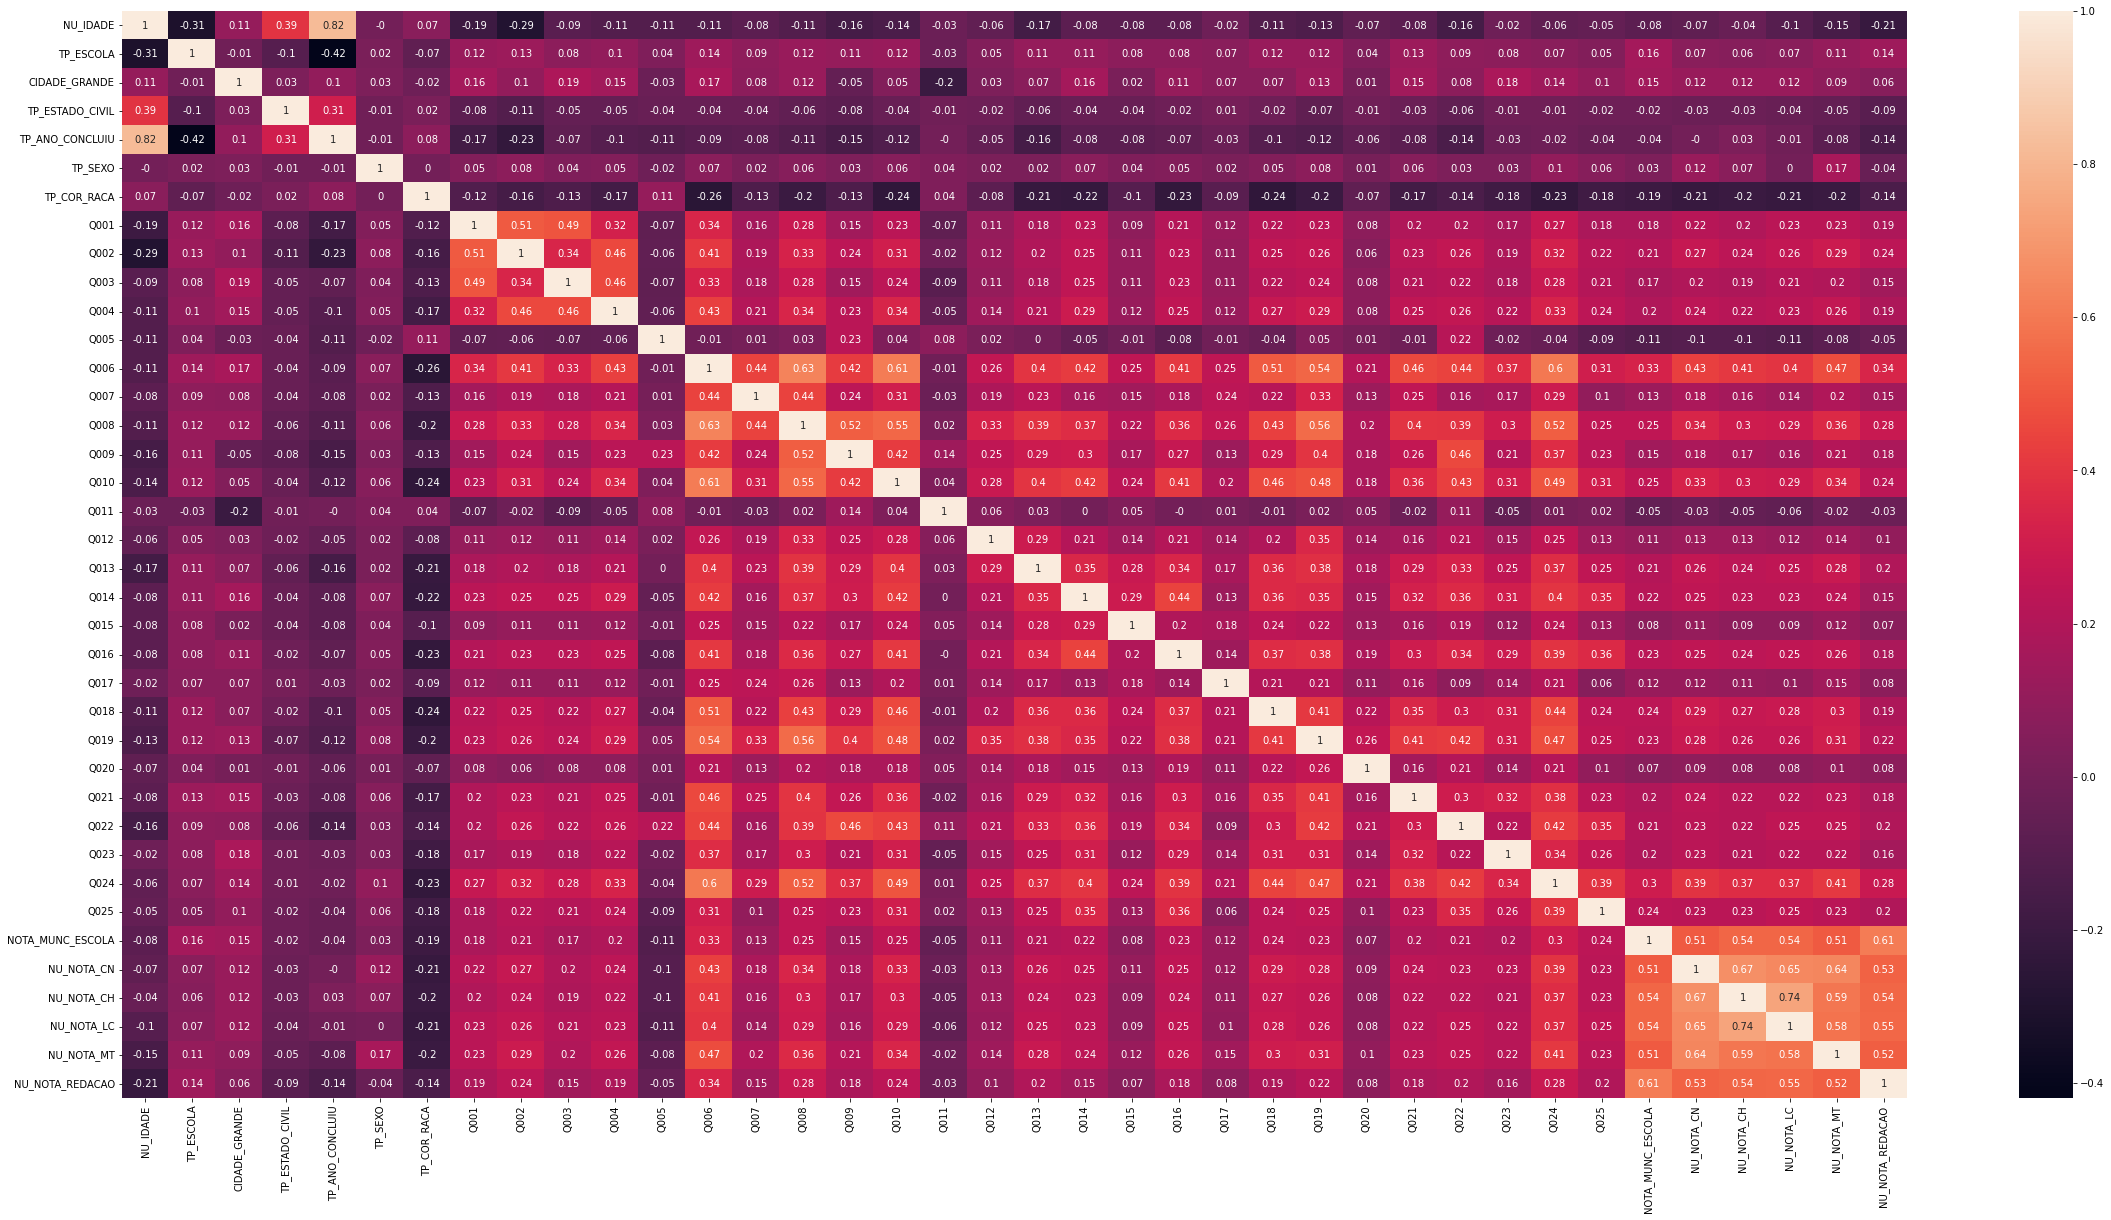

In [ ]:
plt.figure(figsize = (40,20))

sn.heatmap(pd.concat([X.reset_index(), Y.reset_index()], axis = 1).drop('index', axis = 1).corr().round(2), annot = True)

# Modelo

In [ ]:
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

X_train, X_test, y_train_model, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

## NU_NOTA_CN

In [ ]:
xgb = XGBRegressor(seed = 20, 
                   tree_method = 'gpu_hist',
                   subsample =  0.7, 
                   n_estimators = 1000, 
                   max_depth = 7, 
                   learning_rate = 0.1, 
                   colsample_bytree = 0.3)

xgb.fit(X_train, y_train_model.iloc[:, 0])


y_pred_nu_nota_cn = xgb.predict(X_test)

print(f"Previsto - RMSE = {np.sqrt(mean_squared_error(y_train_model.loc[:,'NU_NOTA_CN'], xgb.predict(X_train))):.3f}")
print(f"Predito - RMSE = {np.sqrt(mean_squared_error(y_test.loc[:,'NU_NOTA_CN'], y_pred_nu_nota_cn)):.3f}")

[04:33:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Previsto - RMSE = 6.205
Predito - RMSE = 64.085


Antes:

Previsto - RMSE = 61.442
Predito - RMSE = 62.748

## NU_NOTA_CH

In [ ]:
xgb_2 = XGBRegressor(seed = 20, 
                    tree_method = 'gpu_hist',
                   subsample =  0.7, 
                   n_estimators = 1000, 
                   max_depth = 7, 
                   learning_rate = 0.05, 
                   colsample_bytree = 0.3)

xgb_2.fit(X_train, y_train_model.iloc[:, 1])

y_pred_nu_nota_ch = xgb_2.predict(X_test)

print(f"Previsto - RMSE = {np.sqrt(mean_squared_error(y_train_model.loc[:,'NU_NOTA_CH'], xgb_2.predict(X_train))):.3f}")
print(f"Predito - RMSE = {np.sqrt(mean_squared_error(y_test.loc[:,'NU_NOTA_CH'], y_pred_nu_nota_ch)):.3f}")

[04:33:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Previsto - RMSE = 17.538
Predito - RMSE = 65.845


Previsto - RMSE = 66.421
Predito - RMSE = 67.726

## NU_NOTA_LC

In [ ]:
xgb_3 = XGBRegressor(seed = 20, 
                    tree_method = 'gpu_hist',
                   subsample =  0.7, 
                   n_estimators = 1000, 
                   max_depth = 7, 
                   learning_rate = 0.1, 
                   colsample_bytree = 0.3)

xgb_3.fit(X_train, y_train_model.iloc[:, 2])

y_pred_nu_nota_lc = xgb_3.predict(X_test)

print(f"Previsto - RMSE = {np.sqrt(mean_squared_error(y_train_model.loc[:,'NU_NOTA_LC'], xgb_3.predict(X_train))):.3f}")
print(f"Predito - RMSE = {np.sqrt(mean_squared_error(y_test.loc[:,'NU_NOTA_LC'], y_pred_nu_nota_lc)):.3f}")

[04:33:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Previsto - RMSE = 4.886
Predito - RMSE = 51.120


Previsto - RMSE = 50.463
Predito - RMSE = 51.586

## NU_NOTA_MT

In [ ]:
xgb_4 = XGBRegressor(seed = 20, 
                  tree_method = 'gpu_hist',
                   subsample =  0.8, 
                   n_estimators = 1000, 
                   max_depth = 10, 
                   learning_rate = 0.05, 
                   colsample_bytree = 0.25)

xgb_4.fit(X_train, y_train_model.iloc[:, 3])

y_pred_nu_nota_mt = xgb_4.predict(X_test)

print(f"Previsto - RMSE = {np.sqrt(mean_squared_error(y_train_model.loc[:,'NU_NOTA_MT'], xgb_4.predict(X_train))):.3f}")
print(f"Predito - RMSE = {np.sqrt(mean_squared_error(y_test.loc[:,'NU_NOTA_MT'], y_pred_nu_nota_mt)):.3f}")

[04:33:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Previsto - RMSE = 3.267
Predito - RMSE = 87.589


Previsto - RMSE = 81.122
Predito - RMSE = 87.289

## NU_NOTA_REDACAO

In [ ]:
xgb_5 = XGBRegressor(seed = 20, 
                  tree_method = 'gpu_hist',
                   subsample =  0.7, 
                   n_estimators = 1000, 
                   max_depth = 8, 
                   learning_rate = 0.05, 
                   colsample_bytree = 0.3)

xgb_5.fit(X_train, y_train_model.iloc[:, 4])

y_pred_nu_nota_red = xgb_5.predict(X_test)

print(f"Previsto - RMSE = {np.sqrt(mean_squared_error(y_train_model.loc[:,'NU_NOTA_REDACAO'], xgb_5.predict(X_train))):.3f}")
print(f"Predito - RMSE = {np.sqrt(mean_squared_error(y_test.loc[:,'NU_NOTA_REDACAO'], y_pred_nu_nota_red)):.3f}")

[04:34:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Previsto - RMSE = 15.464
Predito - RMSE = 119.135


Previsto - RMSE = 131.981
Predito - RMSE = 132.498

# TESTE DATA

In [ ]:
test = pd.read_csv(os.path.join(dir_base, 'test.csv'))#.sample(n=10000)

not_tested = test.query('TP_PRESENCA_CN != 1 and TP_PRESENCA_CH != 1 and TP_PRESENCA_LC != 1 and TP_PRESENCA_MT != 1 and TP_STATUS_REDACAO != 1')

# not_tested = test.query('TP_PRESENCA_CN != 1 or TP_PRESENCA_CH != 1 or TP_PRESENCA_LC != 1 or TP_PRESENCA_MT != 1 or TP_STATUS_REDACAO != 1')

# test = test.query('TP_PRESENCA_CN == 1 and TP_PRESENCA_CH == 1 and TP_PRESENCA_LC == 1 and TP_PRESENCA_MT == 1 and TP_STATUS_REDACAO == 1')

c = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']
not_tested = not_tested.assign(**dict.fromkeys(c, 0))

In [ ]:
Qs = []

for i in range(1,26):
    if i < 10:
        q = 'Q00' + str(i)
    else:
        q = 'Q0' + str(i)
    Qs.append(q)

In [ ]:
allfeatures = ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'TP_STATUS_REDACAO', 'NU_INSCRICAO','NO_MUNICIPIO_RESIDENCIA', 'SG_UF_RESIDENCIA','CO_ESCOLA', 'NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL', 
             'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO','TP_ESCOLA', 'TP_ANO_CONCLUIU'] + Qs

features = ['NO_MUNICIPIO_RESIDENCIA', 'TP_ESCOLA','SG_UF_RESIDENCIA', 'CO_ESCOLA','NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL', 
            'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO'] + Qs

abt_test = test.loc[:, allfeatures].copy()

In [ ]:
averageAge = round(abt_test['NU_IDADE'].mean(),3)
abt_test['NU_IDADE'] = abt_test['NU_IDADE'].fillna(averageAge)

In [ ]:
def CidadeGrande(col):
    if col not in listaMuncs:
        return 0
    else:
        return 1

abt_test['CIDADE_GRANDE'] = abt_test.NO_MUNICIPIO_RESIDENCIA.apply(CidadeGrande)

In [ ]:
QsDF = abt_test.loc[:, Qs].apply(le_QsDF.fit_transform)

QsDF = pd.DataFrame(scaler_QsDF.transform(QsDF), columns = QsDF.columns)

QsDF.head()

,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,0.142857,0.571429,0.4,0.4,0.285714,0.2500,0.000000,0.50,0.75,0.25,...,0.25,0.0,0.0,0.25,0.0,0.0,0.75,0.0,0.25,1.0
1,0.571429,0.571429,0.4,0.2,0.214286,0.1250,0.000000,0.50,0.50,0.25,...,0.25,0.0,1.0,0.50,0.0,1.0,1.00,0.0,0.25,1.0
2,0.285714,0.857143,0.4,0.2,0.285714,0.3750,0.000000,0.25,0.50,0.00,...,0.00,0.0,0.0,0.25,0.0,0.0,0.75,0.0,0.00,1.0
3,0.142857,0.285714,0.0,0.0,0.142857,0.0625,0.333333,0.25,0.50,0.00,...,0.00,0.0,0.0,0.25,0.0,0.0,0.50,0.0,0.25,1.0
4,0.285714,0.142857,0.2,0.2,0.071429,0.1250,0.000000,0.25,0.25,0.00,...,0.25,0.0,0.0,0.25,0.0,0.0,0.50,0.0,0.00,1.0


In [ ]:
cols = ['TP_SEXO', 'TP_COR_RACA']

TpInDF = abt_test[cols].apply(le_TpInDF.fit_transform)
TpInDF = pd.concat([abt_test[['NU_IDADE', 'CO_ESCOLA','TP_ESCOLA', 'CIDADE_GRANDE', 'TP_ESTADO_CIVIL','TP_ANO_CONCLUIU']], TpInDF ], axis=1)

TpInDF = pd.DataFrame(scaler_TpInDF.fit_transform(TpInDF), columns = TpInDF.columns)
TpInDF.head()

TpInDF.head()

,NU_IDADE,CO_ESCOLA,TP_ESCOLA,CIDADE_GRANDE,TP_ESTADO_CIVIL,TP_ANO_CONCLUIU,TP_SEXO,TP_COR_RACA
0,0.089286,0.358502,0.5,0.0,0.25,0.000000,1.0,0.2
1,0.071429,0.359332,1.0,1.0,0.25,0.000000,1.0,0.6
2,0.053571,0.927444,0.5,0.0,0.25,0.000000,0.0,0.2
3,0.160714,NaN,0.0,1.0,0.25,0.461538,0.0,0.6
4,0.142857,NaN,0.0,1.0,0.25,0.384615,1.0,0.2


In [ ]:
UfDF = pd.get_dummies(data = abt_test["SG_UF_RESIDENCIA"])

abt_test = abt_test.merge(grouped_schools.reset_index()[['NU_GERAL_BY_SCHOOL','CO_ESCOLA']], on='CO_ESCOLA', how='left')
abt_test = abt_test.merge(grouped_munc.reset_index()[['NU_GERAL_BY_SCHOOL','NO_MUNICIPIO_RESIDENCIA']], on='NO_MUNICIPIO_RESIDENCIA', how='left')

abt_test['NOTA_MUNC_ESCOLA'] = np.where(abt_test["NU_GERAL_BY_SCHOOL_x"].isnull(), abt_test["NU_GERAL_BY_SCHOOL_y"], abt_test["NU_GERAL_BY_SCHOOL_x"])


In [ ]:
#scaler = preprocessing.MinMaxScaler()

Schools_infos = pd.DataFrame(scaler.transform(abt_test[['NOTA_MUNC_ESCOLA']]), columns = ['NOTA_MUNC_ESCOLA'])
Schools_infos.head()

,NOTA_MUNC_ESCOLA
0,0.540339
1,0.478594
2,0.296962
3,0.520967
4,0.504161


In [ ]:

cols = ['NU_INSCRICAO', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'TP_STATUS_REDACAO',]
presence_student =abt_test.loc[:, cols]


In [ ]:
X_test_set = pd.concat([presence_student, TpInDF, QsDF, Schools_infos], axis=1)

In [ ]:
X_test_set.drop('CO_ESCOLA', axis = 1, inplace = True)

In [ ]:
print(X.shape, X_test_set.shape)

(7021, 33) (10000, 39)


In [ ]:
cn = X_test_set[X_test_set['TP_PRESENCA_CN'] == 1]
ch = X_test_set[X_test_set['TP_PRESENCA_CH'] == 1]
lc = X_test_set[X_test_set['TP_PRESENCA_LC'] == 1]
mt = X_test_set[X_test_set['TP_PRESENCA_MT'] == 1]
rd = X_test_set[X_test_set['TP_STATUS_REDACAO'] == 1]

y_real_nu_nota_cn = xgb.predict(cn.iloc[:,6:])
y_real_nu_nota_ch = xgb_2.predict(ch.iloc[:,6:])
y_real_nu_nota_lc = xgb_3.predict(lc.iloc[:,6:])
y_real_nu_nota_mt = xgb_4.predict(mt.iloc[:,6:])
y_real_nu_nota_red = xgb_5.predict(rd.iloc[:,6:])

In [ ]:
testeDF = X_test_set['NU_INSCRICAO'].copy()

cn = pd.DataFrame({
    'NU_INSCRICAO': cn['NU_INSCRICAO'],
    'NU_NOTA_CN': y_real_nu_nota_cn,
    }
)
ch = pd.DataFrame({
    'NU_INSCRICAO': ch['NU_INSCRICAO'],
    'NU_NOTA_CH': y_real_nu_nota_ch,
    }
)
lc = pd.DataFrame({
    'NU_INSCRICAO': lc['NU_INSCRICAO'],
    'NU_NOTA_LC': y_real_nu_nota_lc,
    }
)
mt = pd.DataFrame({
    'NU_INSCRICAO': mt['NU_INSCRICAO'],
    'NU_NOTA_MT': y_real_nu_nota_mt,
    }
)
rd = pd.DataFrame({
    'NU_INSCRICAO': rd['NU_INSCRICAO'],
    'NU_NOTA_REDACAO': pd.DataFrame(y_real_nu_nota_red).iloc[:,0].values,
    }
)

testeDF = pd.merge(testeDF, cn, how='left',  on="NU_INSCRICAO")
testeDF = pd.merge(testeDF, ch, how='left',on="NU_INSCRICAO")
testeDF = pd.merge(testeDF, lc, how='left', on="NU_INSCRICAO")
testeDF = pd.merge(testeDF, mt, how='left', on="NU_INSCRICAO")
testeDF = pd.merge(testeDF, rd, how='left', on="NU_INSCRICAO")
testeDF.fillna(0.0, inplace=True)
testeDF.head()

,NU_INSCRICAO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
0,9dc9369a-2735-4799-adef-4cbe38c06b00,497.183319,523.649597,514.986023,547.052734,570.556885
1,958b4675-59bf-4923-9e71-370fcc9d0749,472.697815,504.083649,536.060120,528.634705,561.615295
2,e1aa6800-4ea0-4fae-82b5-0ccd80a18070,474.686310,440.521454,492.596802,502.111176,497.802643
3,ed2ea0ef-bf8d-4959-b419-0572e57c6a41,0.000000,0.000000,0.000000,0.000000,0.000000
4,3ff084f4-9d78-4c2d-bc71-b66019f165c8,465.394897,518.861755,530.902344,548.356262,536.446106


In [ ]:
testeDF.to_csv(os.path.join(dir_base, 'FinalTry.csv'), index = False)